# Project Title
### Data Engineering Capstone Project

#### Project Summary

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
import findspark
findspark.init()

findspark.find()
import pyspark
findspark.find()

'C:\\spark-3.1.2-bin-hadoop3.2'

In [2]:
# Do all imports and installs here
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when, count, date_add , expr, udf, to_date, create_map, lit, year,length, regexp_replace, lower
from pyspark.sql.types import DateType
import datetime
from pyspark.sql import DataFrameNaFunctions as na
from Bio.Seq import Seq
from itertools import chain
import configparser

import psycopg2
from sql_queries import insert_country_dim,insert_state_dim,insert_visa_dim,insert_imigration_fact

In [3]:
from sql_queries import insert_country_dim,insert_state_dim,insert_visa_dim,insert_imigration_fact


### Step 1: Scope the Project and Gather Data

#### Scope 
this project aims to find patterns and answers to questions such as what is the the most favorit state in us for immigrant ,if thre is a pattern between originale country and destitnation state (for temperatures) ..

for this i'm gonna use 3 different datasets and combining them to create a datawarehouse using hadoop hdfs as our fileSystem , Spark (pyspark) for cleaning exploring and creating our ETL and postgresDB as our database 


#### Describe and Gather Data 
in this project we will use 3 different dataset :
###### I94 Immigration Data: 
This data comes from the US National Tourism and Trade Office.
###### World Temperature Data: 
This dataset came from Kaggle and contains records for weather temperatures .
###### U.S. City Demographic Data:
This data comes from OpenSoft and contains information about the demographics of USA cities.

In [4]:
#add path to psql jar drive 
pathPsql = "C:\\Users\\faycalMEROUANE\\Desktop\\udacity work\\dataset\\postgresql-42.2.23.jar"

In [5]:
spark = SparkSession.builder.appName('udacity capstone project').config("spark.jars", pathPsql).master("local[*]").getOrCreate()

In [6]:
# Read US Immigration data 
us_immigration_df = spark.read.parquet("hdfs://192.168.0.51:9000/udacity/data/*.parquet")
us_immigration_df.count()



3096313

In [7]:
# describe us_immigration_df
us_immigration_df.limit(10).toPandas().head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1


In [8]:
us_immigration_df.limit(10).toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cicid     10 non-null     float64
 1   i94yr     10 non-null     float64
 2   i94mon    10 non-null     float64
 3   i94cit    10 non-null     float64
 4   i94res    10 non-null     float64
 5   i94port   10 non-null     object 
 6   arrdate   10 non-null     float64
 7   i94mode   10 non-null     float64
 8   i94addr   10 non-null     object 
 9   depdate   10 non-null     float64
 10  i94bir    10 non-null     float64
 11  i94visa   10 non-null     float64
 12  count     10 non-null     float64
 13  dtadfile  10 non-null     object 
 14  visapost  10 non-null     object 
 15  occup     0 non-null      object 
 16  entdepa   10 non-null     object 
 17  entdepd   10 non-null     object 
 18  entdepu   0 non-null      object 
 19  matflag   10 non-null     object 
 20  biryear   10 non-null     float64
 

In [9]:
# Read world global temp by city (csv file)
global_tempe_by_city_df = spark.read.option("header", "true").csv("hdfs://192.168.0.51:9000/udacity/data/GlobalLandTemperaturesByCity.csv")
global_tempe_by_city_df.count()


8599212

In [10]:
# Read world global temp by city (csv file)
global_tempe_by_State_df = spark.read.option("header", "true").csv("hdfs://192.168.0.51:9000/udacity/data/GlobalLandTemperaturesByState.csv")
global_tempe_by_State_df.count()

645675

In [11]:
global_tempe_by_State_df.limit(10).toPandas().head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [12]:
# describe Global_tempe_by_city_df 
global_tempe_by_city_df.limit(10).toPandas().head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


In [13]:
global_tempe_by_city_df.limit(10).toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   dt                             10 non-null     object
 1   AverageTemperature             5 non-null      object
 2   AverageTemperatureUncertainty  5 non-null      object
 3   City                           10 non-null     object
 4   Country                        10 non-null     object
 5   Latitude                       10 non-null     object
 6   Longitude                      10 non-null     object
dtypes: object(7)
memory usage: 688.0+ bytes


In [14]:
# us_cities_demographics (csv file)
us_cities_demographics = spark.read.option("delimiter", ";").option("header", "true").csv("hdfs://192.168.0.51:9000/udacity/data/us-cities-demographics.csv")
us_cities_demographics.count()


2891

In [15]:
# describe us_cities_demographics
us_cities_demographics.limit(10).toPandas().head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [16]:
us_cities_demographics.limit(10).toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   City                    10 non-null     object
 1   State                   10 non-null     object
 2   Median Age              10 non-null     object
 3   Male Population         10 non-null     object
 4   Female Population       10 non-null     object
 5   Total Population        10 non-null     object
 6   Number of Veterans      10 non-null     object
 7   Foreign-born            10 non-null     object
 8   Average Household Size  10 non-null     object
 9   State Code              10 non-null     object
 10  Race                    10 non-null     object
 11  Count                   10 non-null     object
dtypes: object(12)
memory usage: 1.1+ KB


In [17]:
# aireport-code  (csv file)
airport_codes = spark.read.option("header", "true").csv("hdfs://192.168.0.51:9000/udacity/data/airport-codes_csv.csv")
airport_codes.count()

55075

In [18]:
airport_codes.limit(10).toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ident         10 non-null     object
 1   type          10 non-null     object
 2   name          10 non-null     object
 3   elevation_ft  10 non-null     object
 4   continent     10 non-null     object
 5   iso_country   10 non-null     object
 6   iso_region    10 non-null     object
 7   municipality  10 non-null     object
 8   gps_code      9 non-null      object
 9   iata_code     0 non-null      object
 10  local_code    9 non-null      object
 11  coordinates   10 non-null     object
dtypes: object(12)
memory usage: 1.1+ KB


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

##### 1- I94 Immigration Data: 





<AxesSubplot:>

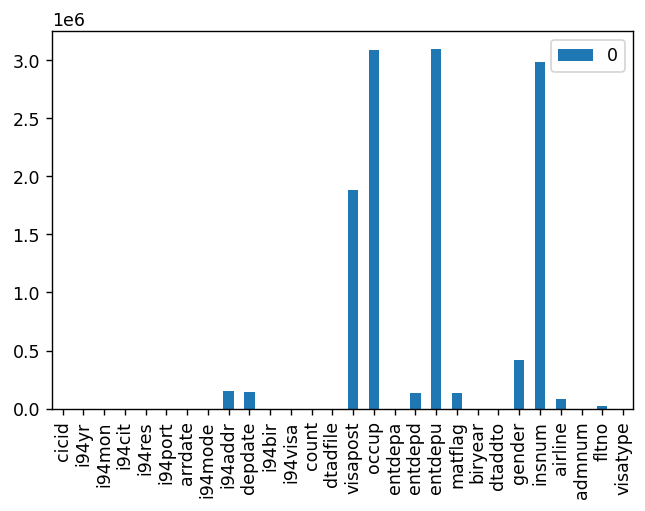

In [19]:
# Identify data quality issues
# visualize the count of columns with null value
plt.rcParams['figure.dpi'] = 125
pd = us_immigration_df.select([count (when (col(c).isNull(), c)).alias(c) for c in us_immigration_df.columns]).toPandas()
pd.T.plot.bar()

In [20]:
#dates = 20582
#epoch = datetime.datetime(1960, 1, 1)
#print(epoch + datetime.timedelta(dates))


In [21]:
#as we can see in this visulalisation w that visapost occup entdepu and insnum columns contain so much nulls values 
#so in this case we can remove them from our dataFrame, 
#Rename columns , select only important columns and convert them to an appropriate type
#remap value in dataFrame 'us_immigration_df' using a dictionary ' from data in SAS labels descriptions '

In [22]:
#creating spark UDF for SAS date format :
epoch = datetime.datetime(1960, 1, 1)
def sas_to_date (sas_date):
    return (epoch + datetime.timedelta(sas_date))
def to_date_fct (x):
    if(len(str(x)) == 8) : 
        return (datetime.datetime.strptime(str(x), '%m%d%Y'))
    else : 
        return None

to_date_fct_dfg = udf(to_date_fct, DateType())
sas_to_date_udf = udf(sas_to_date, DateType())

In [23]:
#dtaddto contains some D/S values so before converting we decide to remove all rows contain D/S in  dtaddto column
us_immigration_df_dtaddto_D = us_immigration_df.filter(us_immigration_df.dtaddto != 'D/S')
#remove spaces
us_immigration_df_dtaddto_clean = us_immigration_df_dtaddto_D.withColumn('dtaddto', regexp_replace(col("dtaddto"), " ", ""))
#verify if we have removed all rows that contain in dtaddto Column D/S values :
us_immigration_df_dtaddto_clean.select("dtaddto").distinct().show()

+--------+
| dtaddto|
+--------+
|09282016|
|02282017|
|01102017|
|11162016|
|10202017|
|11292017|
|06152016|
|01192018|
|11142016|
|03152017|
|03262017|
|07032016|
|07202019|
|04102016|
|06082019|
|05232016|
|08042016|
|03292017|
|08042017|
|04082018|
+--------+
only showing top 20 rows



In [24]:
us_immigration_df_clean = us_immigration_df_dtaddto_clean \
                .withColumn("year", col("i94yr").cast("integer")) \
                .withColumn("month", col("i94mon").cast("integer")) \
                .withColumn("country_citizenship", col("i94cit").cast("integer")) \
                .withColumn("country_residence", col("i94res").cast("integer")) \
                .withColumnRenamed("i94port", "airport_codes_usa") \
                .withColumn("traveled_by", col("i94mode").cast("integer")) \
                .withColumn("country_res_id", col("i94res").cast("integer")) \
                .withColumn("country_citiz_id", col("i94cit").cast("integer")) \
                .withColumnRenamed("i94addr", "code_state_usa") \
                .withColumn("age", col("i94bir").cast("integer")) \
                .withColumn("cicid", col("cicid").cast("integer")) \
                .withColumn("visa_type_issued", col("i94visa").cast("integer")) \
                .withColumn("yeae_of_birth", col("biryear").cast("integer")) \
                .withColumn("visa_end_date", to_date_fct_dfg(col("dtaddto")).cast("date")) \
                .withColumn("arrivaldate", sas_to_date_udf(col("arrdate"))) \
                .drop("i94yr") \
                .drop("i94mon") \
                .drop("i94cit") \
                .drop("i94res") \
                .drop("i94mode") \
                .drop("i94bir") \
                .drop("i94visa") \
                .drop("dtadfile") \
                .drop("visapost") \
                .drop("occup") \
                .drop("entdepu") \
                .drop("insnum") \
                .drop("count") \
                .drop("entdepd") \
                .drop("entdepa") \
                .drop("depdate") \
                .drop("arrdate") \
                .drop("biryear") \
                .drop("dtaddto") \
                .drop("fltno") 

us_immigration_df_clean.limit(10).toPandas()


,cicid,airport_codes_usa,code_state_usa,matflag,gender,airline,admnum,visatype,year,month,country_citizenship,country_residence,traveled_by,country_res_id,country_citiz_id,age,visa_type_issued,yeae_of_birth,visa_end_date,arrivaldate
0,5748517,LOS,CA,M,F,QF,9.495387e+10,B1,2016,4,245,438,1,438,245,40,1,1976,2016-10-29,2016-04-30
1,5748518,LOS,NV,M,F,VA,9.495562e+10,B1,2016,4,245,438,1,438,245,32,1,1984,2016-10-29,2016-04-30
2,5748519,LOS,WA,M,M,DL,9.495641e+10,B1,2016,4,245,438,1,438,245,29,1,1987,2016-10-29,2016-04-30
3,5748520,LOS,WA,M,F,DL,9.495645e+10,B1,2016,4,245,438,1,438,245,29,1,1987,2016-10-29,2016-04-30
4,5748521,LOS,WA,M,M,DL,9.495639e+10,B1,2016,4,245,438,1,438,245,28,1,1988,2016-10-29,2016-04-30
5,5748522,HHW,HI,M,M,NZ,9.498180e+10,B2,2016,4,245,464,1,464,245,57,2,1959,2016-10-29,2016-04-30
6,5748523,HHW,HI,M,F,NZ,9.497969e+10,B2,2016,4,245,464,1,464,245,66,2,1950,2016-10-29,2016-04-30
7,5748524,HHW,HI,M,F,NZ,9.497975e+10,B2,2016,4,245,464,1,464,245,41,2,1975,2016-10-29,2016-04-30
8,5748525,HOU,FL,M,M,NZ,9.497325e+10,B2,2016,4,245,464,1,464,245,27,2,1989,2016-10-29,2016-04-30
9,5748526,LOS,CA,M,F,NZ,9.501355e+10,B2,2016,4,245,464,1,464,245,26,2,1990,2016-10-29,2016-04-30


In [25]:
#create a dictionary of country code ,visa issued
country_dict = {
236:  'AFGHANISTAN',
101:  'ALBANIA',
316:  'ALGERIA',
102:  'ANDORRA',
324:  'ANGOLA',
529:  'ANGUILLA',
518:  'ANTIGUA-BARBUDA',
687:  'ARGENTINA ',
151:  'ARMENIA',
532:  'ARUBA',
438:  'AUSTRALIA',
103:  'AUSTRIA',
152:  'AZERBAIJAN',
512:  'BAHAMAS',
298:  'BAHRAIN',
274:  'BANGLADESH',
513:  'BARBADOS',
104:  'BELGIUM',
581:  'BELIZE',
386:  'BENIN',
509:  'BERMUDA',
153:  'BELARUS',
242:  'BHUTAN',
688:  'BOLIVIA',
717:  'BONAIRE, ST EUSTATIUS, SABA',
164:  'BOSNIA-HERZEGOVINA',
336:  'BOTSWANA',
689:  'BRAZIL',
525:  'BRITISH VIRGIN ISLANDS',
217:  'BRUNEI',
105:  'BULGARIA',
393:  'BURKINA FASO',
243:  'BURMA',
375:  'BURUNDI',
310:  'CAMEROON',
326:  'CAPE VERDE',
526:  'CAYMAN ISLANDS',
383:  'CENTRAL AFRICAN REPUBLIC',
384:  'CHAD',
690:  'CHILE',
245:  'CHINA, PRC',
721:  'CURACAO' ,
270:  'CHRISTMAS ISLAND',
271:  'COCOS ISLANDS',
691:  'COLOMBIA',
317:  'COMOROS',
385:  'CONGO',
467:  'COOK ISLANDS',
575:  'COSTA RICA',
165:  'CROATIA',
584:  'CUBA',
218:  'CYPRUS',
140:  'CZECH REPUBLIC',
723:  'FAROE ISLANDS (PART OF DENMARK)'  ,
108:  'DENMARK',
322:  'DJIBOUTI',
519:  'DOMINICA',
585:  'DOMINICAN REPUBLIC',
240:  'EAST TIMOR',
692:  'ECUADOR',
368:  'EGYPT',
576:  'EL SALVADOR',
399:  'EQUATORIAL GUINEA',
372:  'ERITREA',
109:  'ESTONIA',
369:  'ETHIOPIA',
604:  'FALKLAND ISLANDS',
413:  'FIJI',
110:  'FINLAND',
111:  'FRANCE',
601:  'FRENCH GUIANA',
411:  'FRENCH POLYNESIA',
387:  'GABON',
338:  'GAMBIA',
758:  'GAZA STRIP',
154:  'GEORGIA',
112:  'GERMANY',
339:  'GHANA',
143:  'GIBRALTAR',
113:  'GREECE',
520:  'GRENADA',
507:  'GUADELOUPE',
577:  'GUATEMALA',
382:  'GUINEA',
327:  'GUINEA-BISSAU',
603:  'GUYANA',
586:  'HAITI',
726:  'HEARD AND MCDONALD IS.',
149:  'HOLY SEE/VATICAN',
528:  'HONDURAS',
206:  'HONG KONG',
114:  'HUNGARY',
115:  'ICELAND',
213:  'INDIA',
759:  'INDIAN OCEAN AREAS (FRENCH)' ,
729:  'INDIAN OCEAN TERRITORY' ,
204:  'INDONESIA',
249:  'IRAN',
250:  'IRAQ',
116:  'IRELAND',
251:  'ISRAEL',
117:  'ITALY',
388:  'IVORY COAST',
514:  'JAMAICA',
209:  'JAPAN',
253:  'JORDAN',
201:  'KAMPUCHEA',
155:  'KAZAKHSTAN',
340:  'KENYA',
414:  'KIRIBATI',
732:  'KOSOVO' ,
272:  'KUWAIT',
156:  'KYRGYZSTAN',
203:  'LAOS',
118:  'LATVIA',
255:  'LEBANON',
335:  'LESOTHO',
370:  'LIBERIA',
381:  'LIBYA',
119:  'LIECHTENSTEIN',
120:  'LITHUANIA',
121:  'LUXEMBOURG',
214:  'MACAU',
167:  'MACEDONIA',
320:  'MADAGASCAR',
345:  'MALAWI',
273:  'MALAYSIA',
220:  'MALDIVES',
392:  'MALI',
145:  'MALTA',
472:  'MARSHALL ISLANDS',
511:  'MARTINIQUE',
389:  'MAURITANIA',
342:  'MAURITIUS',
760:  'MAYOTTE (AFRICA - FRENCH)' ,
473:  'MICRONESIA, FED. STATES OF',
157:  'MOLDOVA',
122:  'MONACO',
299:  'MONGOLIA',
735:  'MONTENEGRO' ,
521:  'MONTSERRAT',
332:  'MOROCCO',
329:  'MOZAMBIQUE',
371:  'NAMIBIA',
440:  'NAURU',
257:  'NEPAL',
123:  'NETHERLANDS',
508:  'NETHERLANDS ANTILLES',
409:  'NEW CALEDONIA',
464:  'NEW ZEALAND',
579:  'NICARAGUA',
390:  'NIGER',
343:  'NIGERIA',
470:  'NIUE',
275:  'NORTH KOREA',
124:  'NORWAY',
256:  'OMAN',
258:  'PAKISTAN',
474:  'PALAU',
743:  'PALESTINE' ,
504:  'PANAMA',
441:  'PAPUA NEW GUINEA',
693:  'PARAGUAY',
694:  'PERU',
260:  'PHILIPPINES',
416:  'PITCAIRN ISLANDS',
107:  'POLAND',
126:  'PORTUGAL',
297:  'QATAR',
748:  'REPUBLIC OF SOUTH SUDAN',
321:  'REUNION',
127:  'ROMANIA',
158:  'RUSSIA',
376:  'RWANDA',
128:  'SAN MARINO',
330:  'SAO TOME AND PRINCIPE',
261:  'SAUDI ARABIA',
391:  'SENEGAL',
142:  'SERBIA AND MONTENEGRO',
745:  'SERBIA' ,
347:  'SEYCHELLES',
348:  'SIERRA LEONE',
207:  'SINGAPORE',
141:  'SLOVAKIA',
166:  'SLOVENIA',
412:  'SOLOMON ISLANDS',
397:  'SOMALIA',
373:  'SOUTH AFRICA',
276:  'SOUTH KOREA',
129:  'SPAIN',
244:  'SRI LANKA',
346:  'ST. HELENA',
522:  'ST. KITTS-NEVIS',
523:  'ST. LUCIA',
502:  'ST. PIERRE AND MIQUELON',
524:  'ST. VINCENT-GRENADINES',
716:  'SAINT BARTHELEMY' ,
736:  'SAINT MARTIN' ,
749:  'SAINT MAARTEN' ,
350:  'SUDAN',
602:  'SURINAME',
351:  'SWAZILAND',
130:  'SWEDEN',
131:  'SWITZERLAND',
262:  'SYRIA',
268:  'TAIWAN',
159:  'TAJIKISTAN',
353:  'TANZANIA',
263:  'THAILAND',
304:  'TOGO',
417:  'TONGA',
516:  'TRINIDAD AND TOBAGO',
323:  'TUNISIA',
264:  'TURKEY',
161:  'TURKMENISTAN',
527:  'TURKS AND CAICOS ISLANDS',
420:  'TUVALU',
352:  'UGANDA',
162:  'UKRAINE',
296:  'UNITED ARAB EMIRATES',
135:  'UNITED KINGDOM',
695:  'URUGUAY',
163:  'UZBEKISTAN',
410:  'VANUATU',
696:  'VENEZUELA',
266:  'VIETNAM',
469:  'WALLIS AND FUTUNA ISLANDS',
757:  'WEST INDIES (FRENCH)' ,
333:  'WESTERN SAHARA',
465:  'WESTERN SAMOA',
216:  'YEMEN',
139:  'YUGOSLAVIA',
301:  'ZAIRE',
344:  'ZAMBIA',
315:  'ZIMBABWE',
403:  'INVALID: AMERICAN SAMOA',
712:  'INVALID: ANTARCTICA' ,
700:  'INVALID: BORN ON BOARD SHIP',
719:  'INVALID: BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)',
574:  'INVALID: CANADA',
720:  'INVALID: CANTON AND ENDERBURY ISLS' ,
106:  'INVALID: CZECHOSLOVAKIA',
739:  'INVALID: DRONNING MAUD LAND (ANTARCTICA-NORWAY)' ,
394:  'INVALID: FRENCH SOUTHERN AND ANTARCTIC',
501:  'INVALID: GREENLAND',
404:  'INVALID: GUAM',
730:  'INVALID: INTERNATIONAL WATERS' ,
731:  'INVALID: JOHNSON ISLAND' ,
471:  'INVALID: MARIANA ISLANDS, NORTHERN',
737:  'INVALID: MIDWAY ISLANDS' ,
753:  'INVALID: MINOR OUTLYING ISLANDS - USA',
740:  'INVALID: NEUTRAL ZONE (S. ARABIA/IRAQ)' ,
710:  'INVALID: NON-QUOTA IMMIGRANT',
505:  'INVALID: PUERTO RICO',
 0 :  'INVALID: STATELESS',
705:  'INVALID: STATELESS',
583:  'INVALID: UNITED STATES',
407:  'INVALID: UNITED STATES',
999:  'INVALID: UNKNOWN',
239:  'INVALID: UNKNOWN COUNTRY',
134:  'INVALID: USSR',
506:  'INVALID: U.S. VIRGIN ISLANDS',
755:  'INVALID: WAKE ISLAND',
311:  'Collapsed Tanzania (should not show)',
741:  'Collapsed Curacao (should not show)',
 54:  'No Country Code (54)',
100:  'No Country Code (100)',
187:  'No Country Code (187)',
190:  'No Country Code (190)',
200:  'No Country Code (200)',
219:  'No Country Code (219)',
238:  'No Country Code (238)',
277:  'No Country Code (277)',
293:  'No Country Code (293)',
300:  'No Country Code (300)',
319:  'No Country Code (319)',
365:  'No Country Code (365)',
395:  'No Country Code (395)',
400:  'No Country Code (400)',
485:  'No Country Code (485)',
503:  'No Country Code (503)',
589:  'No Country Code (589)',
592:  'No Country Code (592)',
791:  'No Country Code (791)',
849:  'No Country Code (849)',
914:  'No Country Code (914)',
944:  'No Country Code (944)',
996:  'No Country Code (996)'
}
visa_dict = {
1 : "Business",
2 : "Pleasure",
3 : "Student"
}

In [26]:
#mapping values of Column country_residence, country_citizenship, visa_type_issued and the appropriate dictonary
mapp_expr_country = create_map([lit(item) for item in chain(*country_dict.items())])
mapp_expr_visa = create_map([lit(item) for item in chain(*visa_dict.items())])

us_immigration_df_clean_dict = us_immigration_df_clean.withColumn('country_residence', mapp_expr_country[us_immigration_df_clean['country_residence']])
us_immigration_df_clean_dict = us_immigration_df_clean_dict.withColumn('country_citizenship', mapp_expr_country[us_immigration_df_clean['country_citizenship']])
us_immigration_df_clean_dict = us_immigration_df_clean_dict.withColumn('visa_type_issued', mapp_expr_visa[us_immigration_df_clean['visa_type_issued']])


us_immigration_df_clean_dict.limit(10).toPandas()

,cicid,airport_codes_usa,code_state_usa,matflag,gender,airline,admnum,visatype,year,month,country_citizenship,country_residence,traveled_by,country_res_id,country_citiz_id,age,visa_type_issued,yeae_of_birth,visa_end_date,arrivaldate
0,5748517,LOS,CA,M,F,QF,9.495387e+10,B1,2016,4,"CHINA, PRC",AUSTRALIA,1,438,245,40,Business,1976,2016-10-29,2016-04-30
1,5748518,LOS,NV,M,F,VA,9.495562e+10,B1,2016,4,"CHINA, PRC",AUSTRALIA,1,438,245,32,Business,1984,2016-10-29,2016-04-30
2,5748519,LOS,WA,M,M,DL,9.495641e+10,B1,2016,4,"CHINA, PRC",AUSTRALIA,1,438,245,29,Business,1987,2016-10-29,2016-04-30
3,5748520,LOS,WA,M,F,DL,9.495645e+10,B1,2016,4,"CHINA, PRC",AUSTRALIA,1,438,245,29,Business,1987,2016-10-29,2016-04-30
4,5748521,LOS,WA,M,M,DL,9.495639e+10,B1,2016,4,"CHINA, PRC",AUSTRALIA,1,438,245,28,Business,1988,2016-10-29,2016-04-30
5,5748522,HHW,HI,M,M,NZ,9.498180e+10,B2,2016,4,"CHINA, PRC",NEW ZEALAND,1,464,245,57,Pleasure,1959,2016-10-29,2016-04-30
6,5748523,HHW,HI,M,F,NZ,9.497969e+10,B2,2016,4,"CHINA, PRC",NEW ZEALAND,1,464,245,66,Pleasure,1950,2016-10-29,2016-04-30
7,5748524,HHW,HI,M,F,NZ,9.497975e+10,B2,2016,4,"CHINA, PRC",NEW ZEALAND,1,464,245,41,Pleasure,1975,2016-10-29,2016-04-30
8,5748525,HOU,FL,M,M,NZ,9.497325e+10,B2,2016,4,"CHINA, PRC",NEW ZEALAND,1,464,245,27,Pleasure,1989,2016-10-29,2016-04-30
9,5748526,LOS,CA,M,F,NZ,9.501355e+10,B2,2016,4,"CHINA, PRC",NEW ZEALAND,1,464,245,26,Pleasure,1990,2016-10-29,2016-04-30


In [27]:
#create spark dataframe for us statte and code using SAS labels 
state_df = spark.createDataFrame([{'code_state' : 'AL', 'state_name' :'ALABAMA'},
{'code_state' : 'AK', 'state_name' :'ALASKA'},
{'code_state' : 'AZ', 'state_name' :'ARIZONA'},
{'code_state' : 'AR', 'state_name' :'ARKANSAS'},
{'code_state' : 'CA', 'state_name' :'CALIFORNIA'},
{'code_state' : 'CO', 'state_name' :'COLORADO'},
{'code_state' : 'CT', 'state_name' :'CONNECTICUT'},
{'code_state' : 'DE', 'state_name' :'DELAWARE'},
{'code_state' : 'DC', 'state_name' :'DIST. OF COLUMBIA'},
{'code_state' : 'FL', 'state_name' :'FLORIDA'},
{'code_state' : 'GA', 'state_name' :'GEORGIA'},
{'code_state' : 'GU', 'state_name' :'GUAM'},
{'code_state' : 'HI', 'state_name' :'HAWAII'},
{'code_state' : 'ID', 'state_name' :'IDAHO'},
{'code_state' : 'IL', 'state_name' :'ILLINOIS'},
{'code_state' : 'IN', 'state_name' :'INDIANA'},
{'code_state' : 'IA', 'state_name' :'IOWA'},
{'code_state' : 'KS', 'state_name' :'KANSAS'},
{'code_state' : 'KY', 'state_name' :'KENTUCKY'},
{'code_state' : 'LA', 'state_name' :'LOUISIANA'},
{'code_state' : 'ME', 'state_name' :'MAINE'},
{'code_state' : 'MD', 'state_name' :'MARYLAND'},
{'code_state' : 'MA', 'state_name' :'MASSACHUSETTS'},
{'code_state' : 'MI', 'state_name' :'MICHIGAN'},
{'code_state' : 'MN', 'state_name' :'MINNESOTA'},
{'code_state' : 'MS', 'state_name' :'MISSISSIPPI'},
{'code_state' : 'MO', 'state_name' :'MISSOURI'},
{'code_state' : 'MT', 'state_name' :'MONTANA'},
{'code_state' : 'NC', 'state_name' :'N. CAROLINA'},
{'code_state' : 'ND', 'state_name' :'N. DAKOTA' },
{'code_state' : 'NE', 'state_name' :'NEBRASKA'},
{'code_state' : 'NV', 'state_name' :'NEVADA'},
{'code_state' : 'NH', 'state_name' :'NEW HAMPSHIRE'},
{'code_state' : 'NJ', 'state_name' :'NEW JERSEY'},
{'code_state' : 'NM', 'state_name' :'NEW MEXICO'},
{'code_state' : 'NY', 'state_name' :'NEW YORK'},
{'code_state' : 'OH', 'state_name' :'OHIO'},
{'code_state' : 'OK', 'state_name' :'OKLAHOMA'},
{'code_state' : 'OR', 'state_name' :'OREGON'},
{'code_state' : 'PA', 'state_name' :'PENNSYLVANIA'},
{'code_state' : 'PR', 'state_name' :'PUERTO RICO'},
{'code_state' : 'RI', 'state_name' :'RHODE ISLAND'},
{'code_state' : 'SC', 'state_name' :'S. CAROLINA'},
{'code_state' : 'SD', 'state_name' :'S. DAKOTA'},
{'code_state' : 'TN', 'state_name' :'TENNESSEE'},
{'code_state' : 'TX', 'state_name' :'TEXAS'},
{'code_state' : 'UT', 'state_name' :'UTAH'},
{'code_state' : 'VT', 'state_name' :'VERMONT'},
{'code_state' : 'VI', 'state_name' :'VIRGIN ISLANDS'},
{'code_state' : 'VA', 'state_name' :'VIRGINIA'},
{'code_state' : 'WV', 'state_name' :'W. VIRGINIA'},
{'code_state' : 'WA', 'state_name' :'WASHINGTON'},
{'code_state' : 'WI', 'state_name' :'WISCONSON'},
{'code_state' : 'WY', 'state_name' :'WYOMING' }])
state_df =  state_df.withColumn('state_name', lower(col('state_name')))
state_df.limit(10).toPandas()

,code_state,state_name
0,AL,alabama
1,AK,alaska
2,AZ,arizona
3,AR,arkansas
4,CA,california
5,CO,colorado
6,CT,connecticut
7,DE,delaware
8,DC,dist. of columbia
9,FL,florida


##### 2- World Temperature Data: 





In [28]:
global_tempe_by_city_df.count()

8599212

In [29]:
#us our immigration data is only for the year 2016 we will fillter temp data for only 2016 
#before that we need to extract year from dt column in global_tempe_by_city_df dataframe
#global_tempe_by_city_df_year = global_tempe_by_city_df.withColumn("year", year(col("dt")))
#global_tempe_by_city_df_year.limit(10).toPandas()

In [30]:
#calculate avg temp for each country
avg_tmp_by_country_df_grouped = global_tempe_by_city_df.groupBy("country").agg({'AverageTemperature':'avg'})
avg_tmp_by_country_df_grouped =  avg_tmp_by_country_df_grouped.withColumn('country', lower(col('country')))
avg_tmp_by_country_df_grouped.toPandas()


,country,avg(AverageTemperature)
0,chad,27.189829
1,russia,3.347268
2,paraguay,22.784014
3,yemen,25.768408
4,senegal,25.984177
...,...,...
154,moldova,8.672153
155,congo (democratic republic of the),23.240346
156,vietnam,24.846825
157,netherlands,9.096836


In [31]:
# calculate avg temp for evry state in usa
global_tempe_by_city_df_year_usa = global_tempe_by_State_df.select("*").where(col('country') == 'United States')
avg_tmp_by_country_df_grouped_usa = global_tempe_by_city_df_year_usa.groupBy("State").agg({'AverageTemperature':'avg'})
avg_tmp_by_country_df_grouped_usa.toPandas()

,State,avg(AverageTemperature)
0,Utah,8.478841
1,Hawaii,22.439283
2,Minnesota,4.472812
3,Ohio,10.320152
4,Arkansas,15.573963
5,Oregon,8.165825
6,District Of Columbia,11.918475
7,Georgia (State),17.527082
8,Texas,18.107234
9,North Dakota,4.169715


##### 3- us cities demographic





In [33]:
us_cities_demographics_groupBy_states=us_cities_demographics.groupBy('State').agg({'Male Population' : 'sum', 'Female Population': 'sum', 'Total Population': 'sum'})
us_cities_demographics_groupBy_states.limit(10).toPandas()


,State,sum(Male Population),sum(Total Population),sum(Female Population)
0,Utah,2586752.0,5119677.0,2532925.0
1,Hawaii,884035.0,1763830.0,879795.0
2,Minnesota,3478803.0,7044165.0,3565362.0
3,Ohio,5853254.0,12096550.0,6243296.0
4,Arkansas,1400724.0,2882889.0,1482165.0
5,Oregon,3537215.0,7182545.0,3645330.0
6,Texas,34862194.0,70553853.0,35691659.0
7,North Dakota,476175.0,947450.0,471275.0
8,Pennsylvania,5514704.0,11502801.0,5988097.0
9,Connecticut,2123435.0,4355096.0,2231661.0


In [34]:
#from IPython.display import FileLink, FileLinks

#avg_tmp_by_country_df_grouped_usa.limit(10).toPandas().to_csv('C:\\Users\\faycalMEROUANE\\Desktop\\udacity work\\avg_tmp_by_country_df_grouped_usa.csv', index=False)
#avg_tmp_by_country_df_grouped.limit(10).toPandas().to_csv('C:\\Users\\faycalMEROUANE\\Desktop\\udacity work\\avg_tmp_by_country_df_grouped.csv', index=False)
#us_immigration_df_clean_dict.limit(10).toPandas().to_csv('C:\\Users\\faycalMEROUANE\\Desktop\\udacity work\\us_immigration_df_clean_dict.csv', index=False)
#state_df.toPandas().to_csv('C:\\Users\\faycalMEROUANE\\Desktop\\udacity work\\state_df.csv', index=False)
#us_cities_demographics_groupBy_states.limit(10).toPandas().to_csv('C:\\Users\\faycalMEROUANE\\Desktop\\udacity work\\us_cities_demographics_groupBy_states.csv', index=False)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
<img src="diag.png">

#### 3.2 Mapping Out Data Pipelines
1- first we need to execute the script 'etl_create_and_drop_tables.py' to drop (if exist) tables and recreate them.

2- running the following pipelines to transformae and load data into our DWH.




### Step 4: Run Pipelines to Model the Data 


In [35]:
# first we need to run etl_create_and_drop_tables.py
# using dbever app i verify if the script have created table successfully
# reading database config from a config file and use this information to create a connection to this database
config = configparser.ConfigParser()
config.read('config.cfg')
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['psql'].values()))
cur = conn.cursor()

##### 4.1.1 visa_dim table


In [36]:
us_immigration_df_clean_dict.select("visa_type_issued","visa_end_date").count()


3050493

In [37]:
us_immigration_df_clean_dict.select("visa_type_issued","visa_end_date").dropDuplicates().count()


1267

In [38]:
# insert data to visa_dim 
#for reducing space of our database we can delete all duplicate as as it will not impact our results 
visa_dim = us_immigration_df_clean_dict.select("visa_type_issued","visa_end_date").dropDuplicates().toPandas()
# add visa_id column 
visa_dim['visa_id'] = range(1, len(visa_dim.index)+1)
# rerange column of the dataframe so it will match our table  columns
visa_dim = visa_dim[['visa_id', "visa_type_issued","visa_end_date"]]

for index, row in visa_dim.iterrows():
    cur.execute(insert_visa_dim, list(row.values))
    conn.commit()

    

##### 4.1.2 state_dim table


In [39]:
#making State Column to lower case for joining them with state_df
avg_tmp_by_country_df_grouped_usa =  avg_tmp_by_country_df_grouped_usa.withColumn('State', lower(col('State')))
us_cities_demographics_groupBy_states =  us_cities_demographics_groupBy_states.withColumn('State', lower(col('State')))


In [40]:
#insert data to state_dim

state_dim =state_df.alias('st').join(avg_tmp_by_country_df_grouped_usa.alias('usa_temp'),col('usa_temp.State') == col('st.state_name'),'inner') \
    .join(us_cities_demographics_groupBy_states.alias('demograph'), col('demograph.State') == col('st.state_name'),'inner') \
    .select( col('st.code_state'),col('st.state_name')  \
    ,col('usa_temp.avg(AverageTemperature)')  \
    ,col('demograph.sum(Male Population)')  \
    ,col('demograph.sum(Female Population)')  \
    ,col('demograph.sum(Total Population)')).toPandas()

for index, row in state_dim.iterrows():
    cur.execute(insert_state_dim, list(row.values))
    conn.commit()


##### 4.1.3 country_dim table

In [41]:
#create a dataframe from our country dictionary 
import pandas as pd
country_pd = pd.DataFrame(country_dict,index=['country']).T.reset_index()
country_df = spark.createDataFrame(country_pd)
country_df =  country_df.withColumn('country', lower(col('country'))).withColumnRenamed('index','country_id')
country_df.limit(10).toPandas()


,country_id,country
0,236,afghanistan
1,101,albania
2,316,algeria
3,102,andorra
4,324,angola
5,529,anguilla
6,518,antigua-barbuda
7,687,argentina
8,151,armenia
9,532,aruba


In [42]:
#insert data to country_dim
country_dim = avg_tmp_by_country_df_grouped.alias('country_temp').join(country_df.alias('country') \
                    ,col("country_temp.country") == col("country.country")) \
                    .select(col("country.country_id"),col("country.country"), col("country_temp.avg(AverageTemperature)")) \
                    .toPandas()
#store to database 

for index, row in country_dim.iterrows():
    cur.execute(insert_country_dim, list(row.values))
    conn.commit()

##### 4.1.4 imigration_fact table

In [43]:
#insert data to imigration_fact
immigration_fact= spark.createDataFrame(visa_dim).alias('visa_dim').join(us_immigration_df_clean_dict.alias('immigration') \
                                ,(col('immigration.visa_end_date') == col("visa_dim.visa_end_date"))  \
                                &(col ("immigration.visa_type_issued") == col("visa_dim.visa_type_issued")))\
                                .select(col("immigration.cicid") \
                                        ,col("immigration.gender") \
                                        ,col("immigration.age") \
                                        ,col("immigration.arrivaldate") \
                                        ,col("immigration.code_state_usa") \
                                        ,col("visa_dim.visa_id") \
                                        ,col("immigration.country_citiz_id") \
                                       ,col("immigration.country_res_id"))
#store to database 
# as this dataset is huge (more then 3000000 rows ) we will use the spark write function so we can use the spark parallel compute and not loading all data to python RAM 
mode = "overwrite"
url = "jdbc:postgresql://{}/{}".format(config['psql']['HOST'][1:-1],config['psql']['DB_NAME'])
properties = {"user": "{}".format(config['psql']['DB_USER']),"password": "{}".format(config['psql']['DB_PASSWORD']),"driver": "org.postgresql.Driver"}
immigration_fact.write.jdbc(url=url, table="imigration_fact", mode=mode, properties=properties)

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [44]:
#Perform quality checks here
#Integrity constraints on the relational databas are add using sql query (for exemple premary key and foreign key)
#count the number of rows in all tables of our DWH 
cur.execute("SELECT COUNT(*) FROM imigration_fact ;")
conn.commit()
if cur.rowcount < 1:
    print("imigration_fact is empty")
else:
    print("imigration_fact ok")

cur.execute("SELECT COUNT(*) FROM state_dim ;")
conn.commit()
if cur.rowcount < 1:
    print("state_dim is empty")
else:
    print("state_dim ok")

cur.execute("SELECT COUNT(*) FROM visa_dim ;" )
conn.commit()
if cur.rowcount < 1:
    print("visa_dim is empty")
else:
    print("visa_dim ok")

cur.execute("SELECT COUNT(*) FROM country_dim ;")
conn.commit()
if cur.rowcount < 1:
    print("country_dim is empty")
else:
    print("country_dim ok")


imigration_fact ok
state_dim ok
visa_dim ok
country_dim ok


In [45]:
# close the connection to the database 
conn.close()

#### 4.3 Data dictionary 
##### imigration_fact table : 

| Column | Description |
| :- | :- |
| cicid | unique id|
| gender | individual gender |
| age | individual age |
| arrival_date | arrivale date to usa |
| code_state | usa state distination |
| visa_id | unique visa id auto generated from the combination of visa type and visa end date |
| country_citiz_id | country of citizenship |
| country_res_id | country of residence |

##### visa_dim table :

| Column | Description |
| :- | :- |
| visa_id | unique visa id auto generated from the combination of visa type and visa end date |
| visa_type_issued | the type of vissa issued: Business Pleasure Student|
| visa_end_date | visa end date |
 
##### state_dim table : 

| Column | Description |
| :- | :- |
| code_state | USA code of the state  |
| state_name | USA state full name  |
| state_avg_tmp | the average temperature in the State |
| male_population | population size grouped by male  |
| female_population | population size grouped by female   |
| totalPopulatio | totale population size |

##### country_dim table : 

| Column | Description |
| :- | :- |
| country_id | couontry code from SAS description |
| country_name | full country name  |
| country_avg_tmp |  the average temperature in the country  |

#### 4.4 Process result and visualize: 

1. as finale result user can create a view for exemple : 
```sql
CREATE VIEW udacity_chart AS (select imig.gender, imig.age, country.country_name , state.state_name, country.country_avg_tmp ,state.state_avg_tmp   from imigration_fact imig
join state_dim state on imig.code_state_usa  = state.code_state
JOIN country_dim country ON imig.country_citiz_id = country.country_id) ;
```

2. then using a data exploration software in my case apache superset we can visualize our data :

###### Number of immigrant by country (splited by gender)

<img src="country_by_gender.PNG">

###### most favorite state by country

<img src="udacity.png">




#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

* state the rationale for the choice of tools and technologies for the project : 
    * spark : Apache Spark is a data processing framework that can quickly perform processing tasks on very large data sets and in our case our data is relativly big 
    * Hadoop HDFS : HDFS is highly fault-tolerant and is designed to be deployed on low-cost hardware; HDFS provides high throughput access to application data and is suitable for applications that have large data sets; also the big adventage is hdfs work very well with spark 
* Propose how often the data should be updated and why : 
    * the data could be updated annually or monthly because the type of analytics that run on this DWH require big data so the difference start to shown

* Write a description of how you would approach the problem differently under the following scenarios:
    * The data was increased by 100x : 
        * i would add a stagging step in my ETL pipeline and maybe increese the number of machine in spark/HDFS cluster. 
    * The data populates a dashboard that must be updated on a daily basis by 7am every day.:
        * for that the use of a workflow management platform like airflow will make the job done by creating DAG pipleline and run this dag evry day at 7 pm 
     * The database needed to be accessed by 100+ people. :
         * for that i prefere creating a cluster of Amazon redshift database . and/or making 2 type of database 1- for writes operations and the other for the read operations so we dont slow them (making sure to update the read database evry time that the utl run )